In [1]:
#!pip install ib_insync
#!pip install bs4
from ib_insync import *
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import quantstats as qs

In [2]:
util.startLoop()
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1)

<IB connected to 127.0.0.1:7497 clientId=1>

In [3]:
ib.run()

In [4]:
def extract_info(accounts, tag):
    for acc in accounts:
        if tag == acc.tag:
            return acc.value
    return None

In [5]:
account = ib.accountSummary()
print("Net worth:", extract_info(account, "NetLiquidation"))
print("Cash:", extract_info(account, "TotalCashValue"))

Net worth: 1050244.73
Cash: 932524.33


In [6]:
stock = Stock('META', 'SMART', 'USD', primaryExchange='NASDAQ')
bars = ib.reqHistoricalData(stock, endDateTime = '', durationStr = '3 D', barSizeSetting = '30 secs', whatToShow = 'ADJUSTED_LAST', useRTH = True, formatDate = 2)

In [7]:
print(stock)

Stock(symbol='META', exchange='SMART', primaryExchange='NASDAQ', currency='USD')


In [8]:
ib.qualifyContracts(stock)

[Stock(conId=107113386, symbol='META', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='META', tradingClass='NMS')]

In [9]:
dfBars = util.df(bars)
# dfBars = dfBars.set_index('date')
dfBars

date    open    high     low   close    volume  \
0    2024-05-23 13:30:00+00:00  472.88  473.48  472.00  472.80  190312.0   
1    2024-05-23 13:30:30+00:00  472.89  474.36  472.89  473.32   52269.0   
2    2024-05-23 13:31:00+00:00  473.38  474.00  472.57  472.80   18877.0   
3    2024-05-23 13:31:30+00:00  472.84  473.24  471.90  471.95   24281.0   
4    2024-05-23 13:32:00+00:00  471.91  472.00  471.16  471.45   30177.0   
...                        ...     ...     ...     ...     ...       ...   
1916 2024-05-28 16:28:00+00:00  476.88  476.88  476.88  476.88     245.0   
1917 2024-05-28 16:28:30+00:00  476.85  476.85  476.85  476.85     100.0   
1918 2024-05-28 16:29:00+00:00  476.94  476.95  476.94  476.95     297.0   
1919 2024-05-28 16:29:30+00:00  476.95  476.95  476.95  476.95       0.0   
1920 2024-05-28 16:30:00+00:00  476.95  476.95  476.95  476.95       0.0   

      average  barCount  
0     472.751       236  
1     473.655       258  
2     473.211       126  
3     472.446       138  
4     471.621       213  
...       ...       ...  
1916  476.880         2  
1917  476.850         1  
1918  476.944         2  
1919  476.950         0  
1920  476.950         0  

[1921 rows x 8 columns]

In [10]:
import typing
import pandas as pd
import numpy as np
import numpy.typing as npt
from utils import load_financial_data
from markov import *
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import AdamW
from models import *
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
from utils import load_financial_data, plot_ts, plot_multi_ts

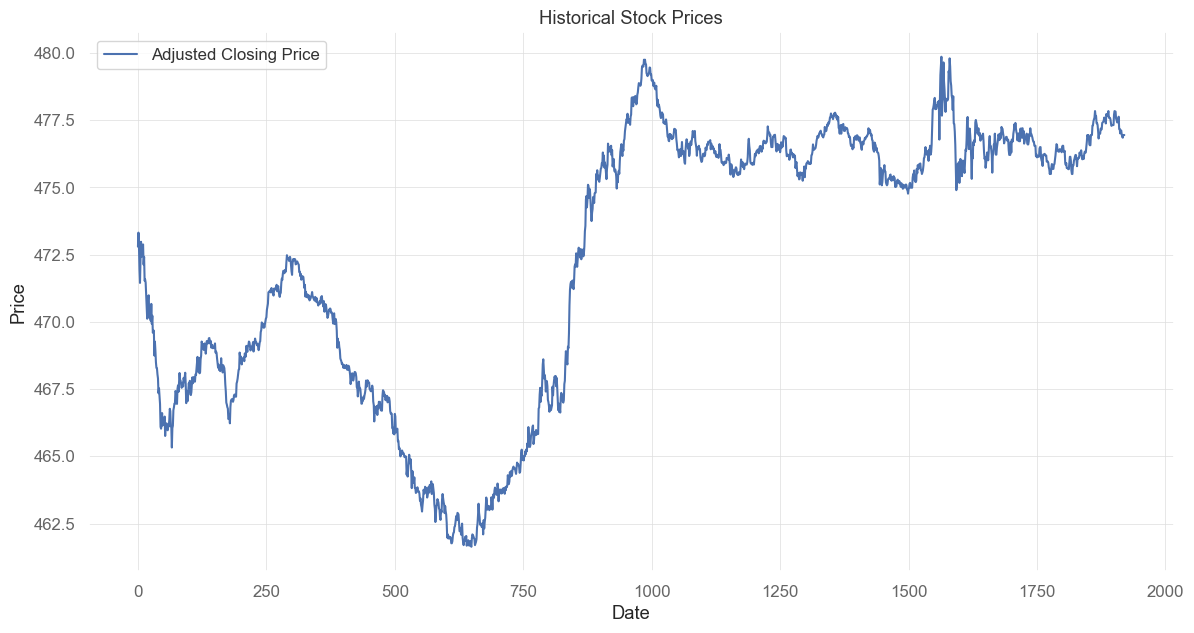

In [12]:
plot_ts(
    data=dfBars["close"], 
    title=f"Historical Stock Prices",
    label_ts="Adjusted Closing Price",
    x_label="Date",
    y_label="Price",
)

In [13]:
security_data = dfBars

In [14]:
from ml import *

In [15]:
markovian_strategy = MLStrategy(
        price=security_data["close"],
        valid_data=security_data["close"],
        test_data=security_data["close"],
        threshold_to_buy=8,
        threshold_to_sell=8,
        lookback=10,
        forward=4,
    )

markovian_strategy.train(
    epochs=100,
    lr=1e-3,
)

100%|██████████| 100/100 [00:15<00:00,  6.67it/s]


In [16]:
markovian_performance = markovian_strategy.backtest(
    initial_cash=1e3,
    num_share_per_trade=1,
    limit_borrow=0,
    limit_num_shorts=0,
    allin=False,
    halfin=False,
)
markovian_performance

  0%|          | 0/1912 [00:00<?, ?it/s]

100%|██████████| 1912/1912 [00:01<00:00, 1208.82it/s]


price  daily_return  signals     cash  positions   wealth
0     472.80      1.000000        0  1000.00       0.00  1000.00
1     473.32      0.001100        0  1000.00       0.00  1000.00
2     472.80     -0.001099        0  1000.00       0.00  1000.00
3     471.95     -0.001798        0  1000.00       0.00  1000.00
4     471.45     -0.001059        0  1000.00       0.00  1000.00
...      ...           ...      ...      ...        ...      ...
1916  476.88     -0.000189        0  1057.91       0.00  1057.91
1917  476.85     -0.000063        1   581.06     476.85  1057.91
1918  476.95      0.000210        1   104.11     953.90  1058.01
1919  476.95      0.000000        0   104.11     953.90  1058.01
1920  476.95      0.000000        0   104.11     953.90  1058.01

[1921 rows x 6 columns]

In [17]:
import matplotlib.pyplot as plt

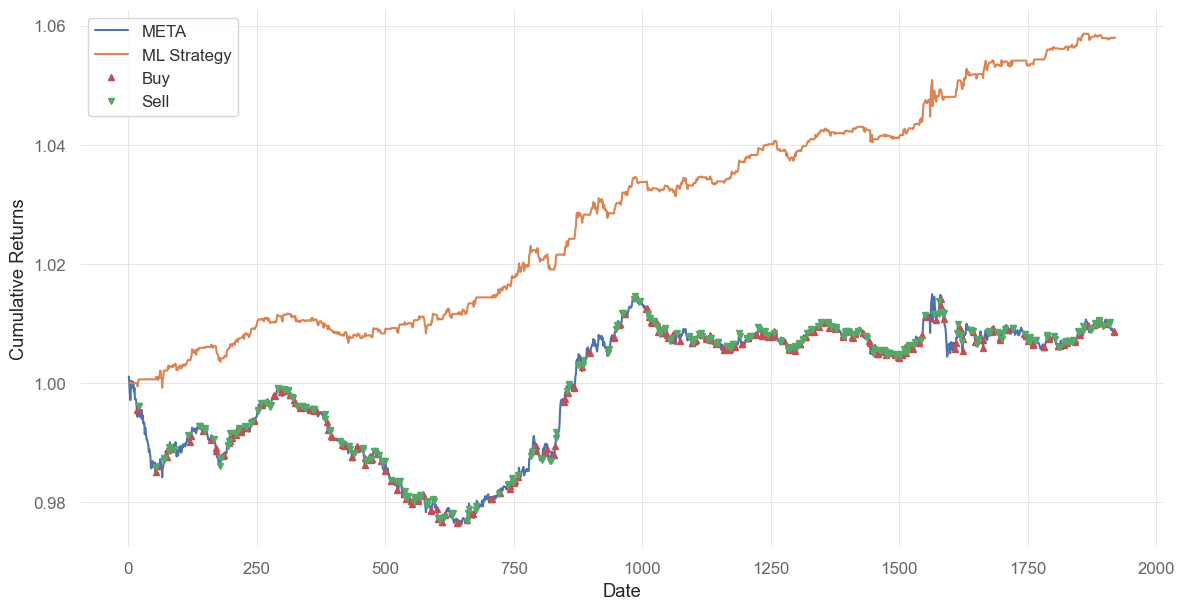

In [18]:
price = security_data["close"]
# price = security_data["Adj Close"]

# Plot both cumulative returns on the same chart 
plt.figure(figsize=(14, 7)) 
plt.plot(price.index, (1 + price.pct_change()).cumprod(), label="META") 
plt.plot(markovian_performance.index, (1 + markovian_performance.wealth.pct_change()).cumprod(), label='ML Strategy')

plt.plot(markovian_performance.loc[markovian_performance.signals == 1.0].index, (1 + price.pct_change()).cumprod()[markovian_performance.signals == 1.0], '^', markersize=5, color='r', label="Buy")
plt.plot(markovian_performance.loc[markovian_performance.signals == -1.0].index, (1 + price.pct_change()).cumprod()[markovian_performance.signals == -1.0], 'v', markersize=5, color='g', label="Sell")


plt.xlabel('Date') 
plt.ylabel('Cumulative Returns') 
plt.legend() 
plt.show()

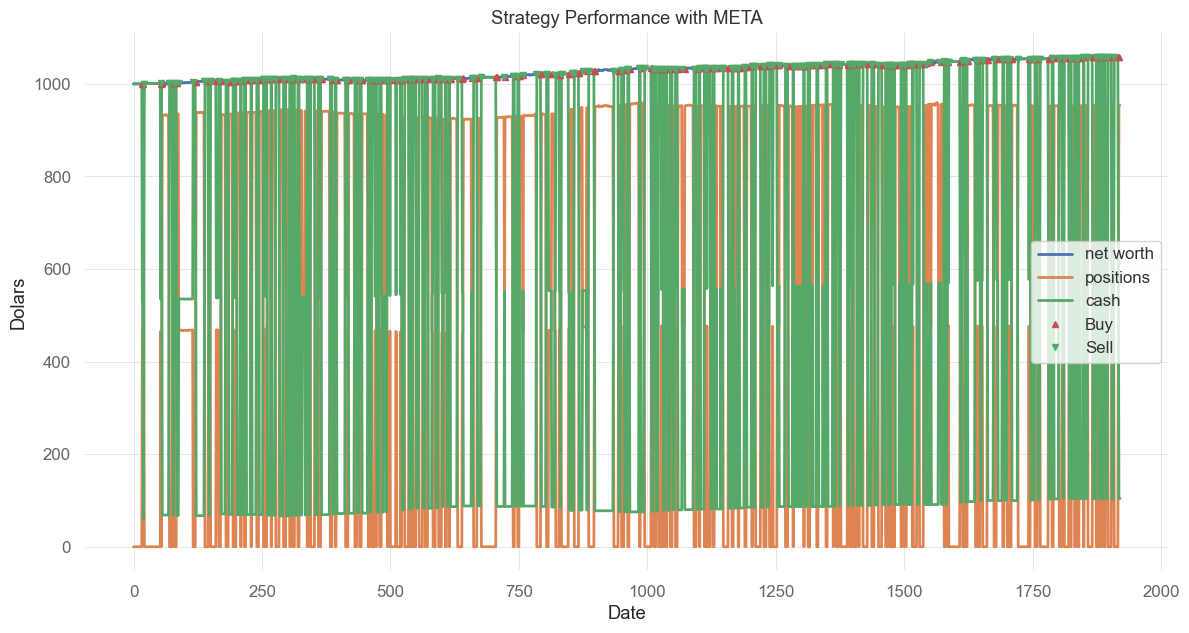

In [19]:
buy_and_hold = price

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(111, ylabel = 'Price in USD')
markovian_performance.wealth.plot(ax=ax1, lw=2., label="net worth")
markovian_performance.positions.plot(ax=ax1, lw=2., label="positions")
markovian_performance.cash.plot(ax=ax1, lw=2., label="cash")

ax1.plot(markovian_performance.loc[markovian_performance.signals == 1.0].index, markovian_performance.wealth[markovian_performance.signals == 1.0], '^', markersize=5, color='r', label="Buy")
ax1.plot(markovian_performance.loc[markovian_performance.signals == -1.0].index, markovian_performance.wealth[markovian_performance.signals == -1.0], 'v', markersize=5, color='g', label="Sell")

plt.xlabel("Date")
plt.ylabel("Dolars")
plt.title(f"Strategy Performance with META")
plt.legend()
plt.show()

In [20]:
ib.sleep(0)
# Use this code to update the transmitted information

True

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
import datetime
datetime.datetime.now().time() >= datetime.time(4, 50)
datetime.datetime.now().time() >= datetime.time(0, 43)

True

In [23]:
ib.disconnect()
markovian_performance = markovian_strategy.deploy(
    ticker="META",
    initial_cash=1e3,
    num_share_per_trade=1,
    limit_borrow=0,
    limit_num_shorts=0,
    allin=False,
    halfin=False,
)
markovian_performance

2024-05-29 01:31:22.251844 Sell
Garthering data for 5 seconds
2024-05-29 01:31:28.351683 Sell
Garthering data for 5 seconds
2024-05-29 01:31:34.181354 Sell
Garthering data for 5 seconds
2024-05-29 01:31:40.017087 Sell
Garthering data for 5 seconds
2024-05-29 01:31:45.849438 Sell
Garthering data for 5 seconds
2024-05-29 01:31:51.850461 No position
Garthering data for 5 seconds
2024-05-29 01:31:57.701098 No position
Garthering data for 5 seconds
2024-05-29 01:32:03.536202 No position
Garthering data for 5 seconds
2024-05-29 01:32:09.545518 No position
Garthering data for 5 seconds
2024-05-29 01:32:15.489899 No position
Garthering data for 5 seconds
2024-05-29 01:32:21.426972 No position
Garthering data for 5 seconds
2024-05-29 01:32:27.253703 No position
Garthering data for 5 seconds
2024-05-29 01:32:45.167239 No position
Garthering data for 5 seconds
2024-05-29 01:33:03.377138 Sell
Garthering data for 5 seconds
2024-05-29 01:33:09.219659 Sell
Garthering data for 5 seconds
2024-05-29 01:

Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.


2024-05-29 01:35:09.012534 No position
Garthering data for 5 seconds


Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: uscrypto; usfarm.nj; cashfarm; usfarm; fundfarm; ushmds; secdefil.


2024-05-29 01:35:54.691405 No position
Garthering data for 5 seconds
2024-05-29 01:36:01.661645 No position
Garthering data for 5 seconds
2024-05-29 01:36:07.474974 No position
Garthering data for 5 seconds
2024-05-29 01:36:15.310672 No position
Garthering data for 5 seconds
2024-05-29 01:36:21.455852 No position
Garthering data for 5 seconds
2024-05-29 01:36:27.292743 No position
Garthering data for 5 seconds
2024-05-29 01:36:33.114239 No position
Garthering data for 5 seconds
2024-05-29 01:36:56.155264 No position
Garthering data for 5 seconds
2024-05-29 01:37:02.155210 Sell
Garthering data for 5 seconds
2024-05-29 01:37:08.163926 Sell
Garthering data for 5 seconds
2024-05-29 01:37:14.166817 Sell
Garthering data for 5 seconds
2024-05-29 01:37:23.226744 Sell
Garthering data for 5 seconds
2024-05-29 01:37:32.954546 No position
Garthering data for 5 seconds
2024-05-29 01:37:39.161373 No position
Garthering data for 5 seconds
2024-05-29 01:37:45.667402 No position
Garthering data for 5 s

reqHistoricalData: Timeout for Stock(symbol='META', exchange='SMART', currency='USD')


TypeError: 'NoneType' object is not subscriptable

Error 366, reqId 346: No historical data query found for ticker id:346, contract: Stock(symbol='META', exchange='SMART', currency='USD')
Peer closed connection.


In [24]:
markovian_performance.to_csv("result-META.csv")